#### Companion notebook for Alphalens tutorial lesson 2

# Creating Tear Sheets With Alphalens

In the previous lesson, you learned what Alphalens is. In this lesson, you will learn a four step process for how to use it:

1. Express an alpha factor and define a trading universe by creating and running a Pipeline over a certain time period.
2. Query pricing data for the assets in our universe during that same time period with `get_pricing()`.
3. Align the alpha factor data with the pricing data with `get_clean_factor_and_forward_returns()`.
4. Visualize how well our alpha factor predicts future price movements with `create_full_tear_sheet()`.

## Build And Run A Pipeline
Execute the following code to express an alpha factor based on asset growth, then run it with `run_pipeline()`

In [1]:
from quantopian.pipeline import Pipeline,CustomFactor
from quantopian.pipeline.data import factset,EquityPricing,Fundamentals
from quantopian.pipeline.factors import SimpleMovingAverage,Returns
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.pipeline.data.psychsignal import stocktwits
import datetime
import quantopian.pipeline.data.factset.estimates as fe
import pandas as pd
import numpy as np
import math
import scipy.stats as stats

/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:8: ZiplineDeprecationWarning: PsychSignal datasets stopped updating on Quantopian on May 1, 2020.
PsychSignal data prior to May 2020 is still available for use on Quantopian;
however, the dataset has stopped updating. For more information see:
https://www.quantopian.com/posts/psychsignal-trader-mood-update

  


In [2]:

class Volatility(CustomFactor):  
    inputs = [USEquityPricing.close]  
    window_length = 20  
    def compute(self, today, assets, out, close):  
        # [0:-1] is needed to remove last close since diff is one element shorter  
        daily_returns = np.diff(close, axis = 0) / close[0:-1]  
        out[:] = daily_returns.std(axis = 0) * math.sqrt(252)

        
class Factor(CustomFactor):  
        """  
        EPS UPGRADES / DOWNGRADES  
        """  
        inputs = [fe.PeriodicConsensus.slice('EPS', 'qf', 1).up, fe.PeriodicConsensus.slice('EPS', 'qf', 1).down]  
        window_length = 1  
        window_safe = True

        def compute(self, today, assets, out, up, down):  
            out[:] = 1.0 * up[-1] / (up[-1] + down[-1])

            
def create_factor():
    #we do the necessary calculations for our surprise factor
    fq0_eps_cons = fe.PeriodicConsensus.slice('EPS', 'qf', 0)  
    fq0_eps_act = fe.Actuals.slice('EPS', 'qf', 0)
    
    fq0_eps_cons_mean = fq0_eps_cons.mean.latest
    fq0_eps_act_value = fq0_eps_act.actual_value.latest
    fq0_surprise = (fq0_eps_act_value - fq0_eps_cons_mean) / fq0_eps_cons_mean
    
    #Factor adapted from Vedran`s video
    fq1_percent = Factor();
    
    
    std_dev = Volatility()
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    
    fq0_eps_cons_volatility = fq0_eps_cons.std_dev.latest

    qtu = QTradableStocksUS()

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    
    fq0_surprise_winsorized = fq0_surprise.winsorize(min_percentile=0.05, max_percentile=0.95)
    fq1_percent_winsorized = fq1_percent.winsorize(min_percentile=0.05, max_percentile=0.95)
    std_dev_winsorized = std_dev.winsorize(min_percentile=0.05, max_percentile=0.95)

    value_winsorized = value.winsorize(min_percentile=0.05, max_percentile=0.95)
    quality_winsorized = quality.winsorize(min_percentile=0.05, max_percentile=0.95)
    fq0_eps_cons_volatility_winsorized = fq0_eps_cons_volatility.winsorize(min_percentile=0.05, max_percentile=0.95)
    
    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    #
    alpha_factor = fq0_surprise_winsorized.zscore() + fq1_percent_winsorized.zscore() + std_dev_winsorized.zscore() + value_winsorized.zscore() + quality_winsorized.zscore() + fq0_eps_cons_volatility_winsorized.zscore() 
    
    return alpha_factor, qtu
 
    
    
def make_pipeline():  
    alpha_factor, qtu = create_factor()
    
    
    screenAlpha = qtu & ~alpha_factor.isnull() & alpha_factor.isfinite()
    
    # Winsorize to remove extreme outliers
    alpha_winsorized = alpha_factor.winsorize(min_percentile=0.01,
                                              max_percentile=0.99,
                                              mask=screenAlpha)
    
    # Zscore and rank to get long and short (positive and negative) alphas to use as weights
    alpha_rank = alpha_winsorized.rank().zscore()
    
    return Pipeline(columns={'alpha_factor': alpha_rank}, 
                    screen=qtu, domain=US_EQUITIES)
    
pipeline_output = run_pipeline(pipeline=make_pipeline(), start_date='2017-05-02', end_date='2019-05-02')

# Show the first 5 rows of factor_data
pipeline_output.head(5) 

alpha_factor
2017-05-02 00:00:00+00:00 Equity(2 [HWM])        0.371585
                          Equity(24 [AAPL])      1.312129
                          Equity(31 [ABAX])     -0.123862
                          Equity(41 [ARCB])     -0.395754
                          Equity(52 [ABM])       0.005035

## Query Pricing Data

Now that we have factor data, let's get pricing data for the same time period. `get_pricing()` returns pricing data for a list of assets over a specified time period. It requires four arguments:
- A list of assets for which we want pricing.
- A start date
- An end date
- Whether to use open, high, low or close pricing.

Execute the following cell to get pricing data.

In [3]:
pricing_data = get_pricing(
    symbols=pipeline_output.index.levels[1], # Finds all assets that appear at least once in "factor_data"  
    start_date='2017-05-02',
    end_date='2019-05-02', # must be after run_pipeline()'s end date. Explained more in lesson 4
    fields='open_price' # Generally, you should use open pricing.
)

# Show the first 5 rows of pricing_data
pricing_data.head(5)

,Equity(2 [HWM]),Equity(21 [AAME]),Equity(24 [AAPL]),Equity(25 [HWM_PR]),Equity(31 [ABAX]),Equity(39 [DDC]),Equity(41 [ARCB]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),...,Equity(53103 [USI]),Equity(53104 [ALTG_WS]),Equity(53105 [SEIX]),Equity(53106 [ALTG]),Equity(53107 [ACTT_U]),Equity(53108 [ETP_PRE]),Equity(53109 [WTRU]),Equity(53112 [WAFU]),Equity(53113 [TPLC]),Equity(53114 [TPHD])
2017-05-02 00:00:00+00:00,26.391,3.599,143.064,83.646,45.127,12.534,25.930,41.784,134.30,42.063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-03 00:00:00+00:00,26.440,3.648,141.173,NaN,45.896,12.504,26.028,41.602,134.15,42.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-04 00:00:00+00:00,26.146,3.697,142.075,NaN,46.863,12.485,25.685,41.813,127.71,42.150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-05 00:00:00+00:00,26.097,3.796,142.308,85.218,47.001,12.248,23.430,41.842,132.13,42.949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-08 00:00:00+00:00,26.665,NaN,144.509,NaN,46.912,12.317,19.214,41.765,132.30,43.065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Align Data

`get_clean_factor_and_forward_returns()` aligns the factor data created by `run_pipeline()` with the pricing data created by `get_pricing()`, and returns an object suitable for analysis with Alphalens' charting functions. It requires two arguments:
- The factor data we created with `run_pipeline()`.
- The pricing data we created with `get_pricing()`.

Execute the following cell to align the factor data with the pricing data.

In [4]:
from alphalens.utils import get_clean_factor_and_forward_returns

factor_data = get_clean_factor_and_forward_returns(
    factor=pipeline_output, 
    prices=pricing_data
)

# Show the first 5 rows of merged_data
factor_data.head(5) 

Dropped 21.3% entries from factor data: 21.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D  \
date                      asset                                             
2017-05-02 00:00:00+00:00 Equity(2 [HWM])    0.001857  0.006328  0.043462   
                          Equity(24 [AAPL]) -0.013218  0.042904  0.061301   
                          Equity(31 [ABAX])  0.017041  0.047865  0.055532   
                          Equity(41 [ARCB])  0.003779 -0.302468 -0.318357   
                          Equity(52 [ABM])  -0.004356 -0.008735 -0.018620   

                                               factor  factor_quantile  
date                      asset                                         
2017-05-02 00:00:00+00:00 Equity(2 [HWM])    0.371585                4  
                          Equity(24 [AAPL])  1.312129                5  
                          Equity(31 [ABAX]) -0.123862                3  
                          Equity(41 [ARCB]) -0.395754                2  
                          Equity(52 [ABM])   0.005035                3

## Visualize Results

Finally, execute the following cell to pass the output of `get_clean_factor_and_forward_returns()` to a function called `create_full_tear_sheet()`. This will create whats known as a tear sheet.

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.731148,-1.032641,-1.384476,0.200427,175082,20.022483
2,-1.041249,-0.340918,-0.691353,0.199883,174787,19.988747
3,-0.348488,0.351130,0.000876,0.199801,174784,19.988404
4,0.343529,1.041309,0.693118,0.199814,174787,19.988747
5,1.035717,1.731148,1.385525,0.200069,174987,20.011619


Returns Analysis


,1D,5D,10D
Ann. alpha,0.004,0.002,0.000
beta,0.065,0.053,0.049
Mean Period Wise Return Top Quantile (bps),1.140,1.083,1.039
Mean Period Wise Return Bottom Quantile (bps),-0.323,-0.060,0.166
Mean Period Wise Spread (bps),1.463,1.140,0.872


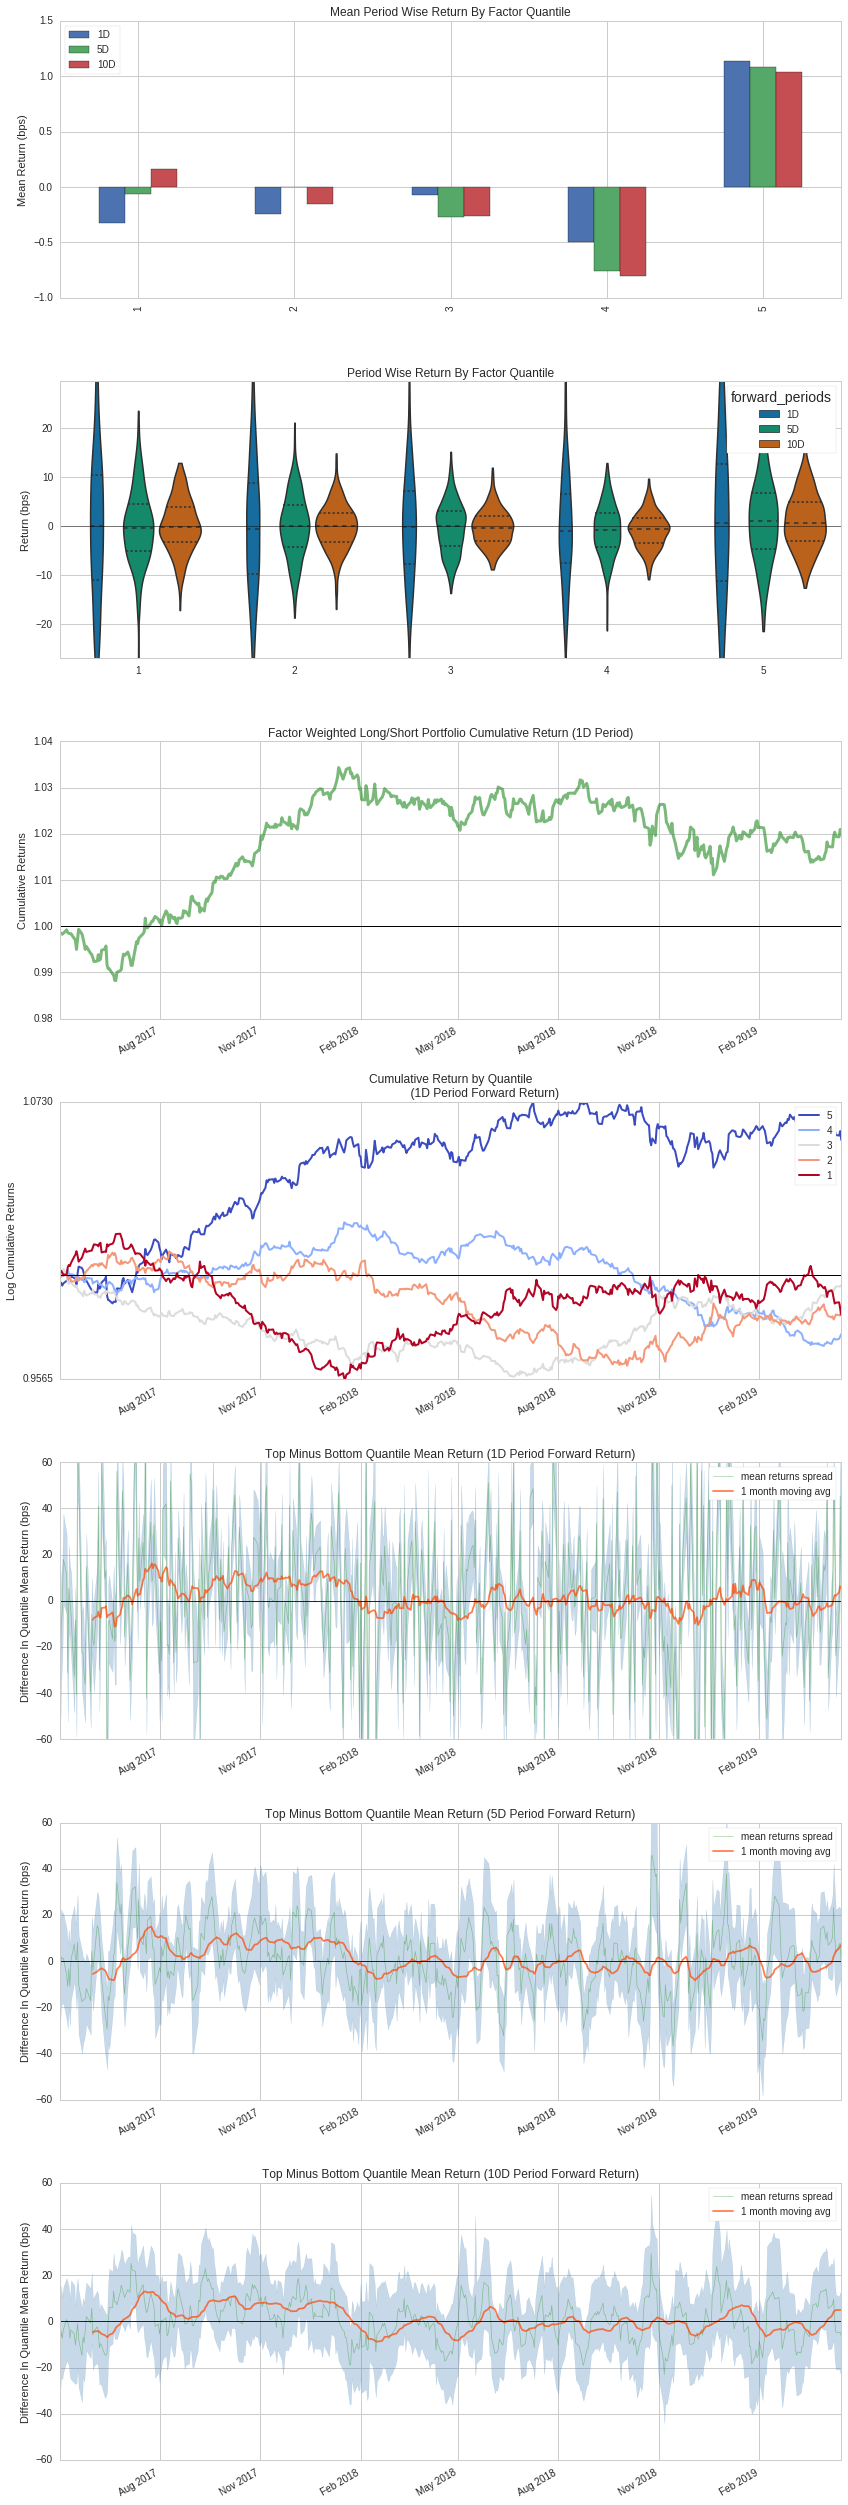

Information Analysis


,1D,5D,10D
IC Mean,0.005,0.005,0.003
IC Std.,0.054,0.053,0.053
Risk-Adjusted IC,0.090,0.086,0.059
t-stat(IC),1.994,1.920,1.313
p-value(IC),0.047,0.055,0.190
IC Skew,-0.079,-0.197,0.074
IC Kurtosis,0.080,-0.210,-0.457


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


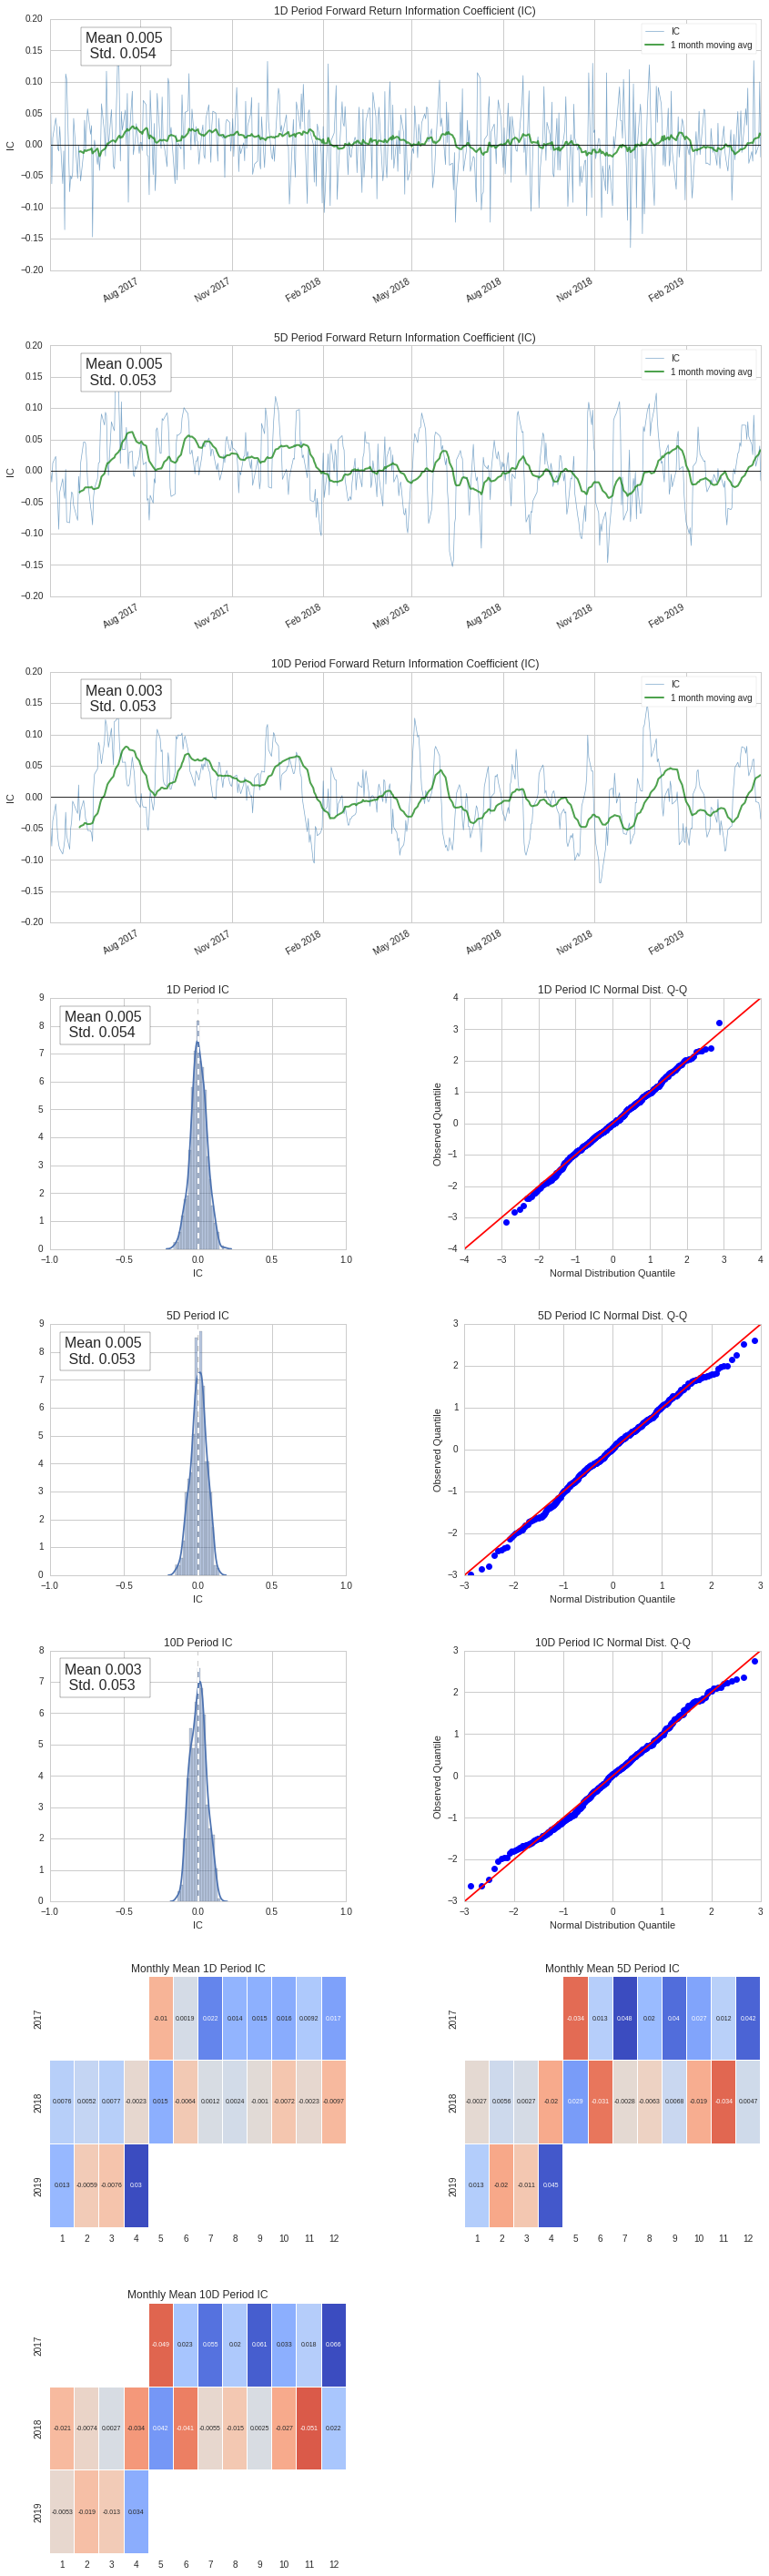

/venvs/py35/lib/python3.5/site-packages/alphalens/utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.052,0.173,0.277
Quantile 2 Mean Turnover,0.094,0.281,0.422
Quantile 3 Mean Turnover,0.102,0.304,0.454
Quantile 4 Mean Turnover,0.090,0.272,0.414
Quantile 5 Mean Turnover,0.044,0.146,0.237


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.985,0.927,0.856


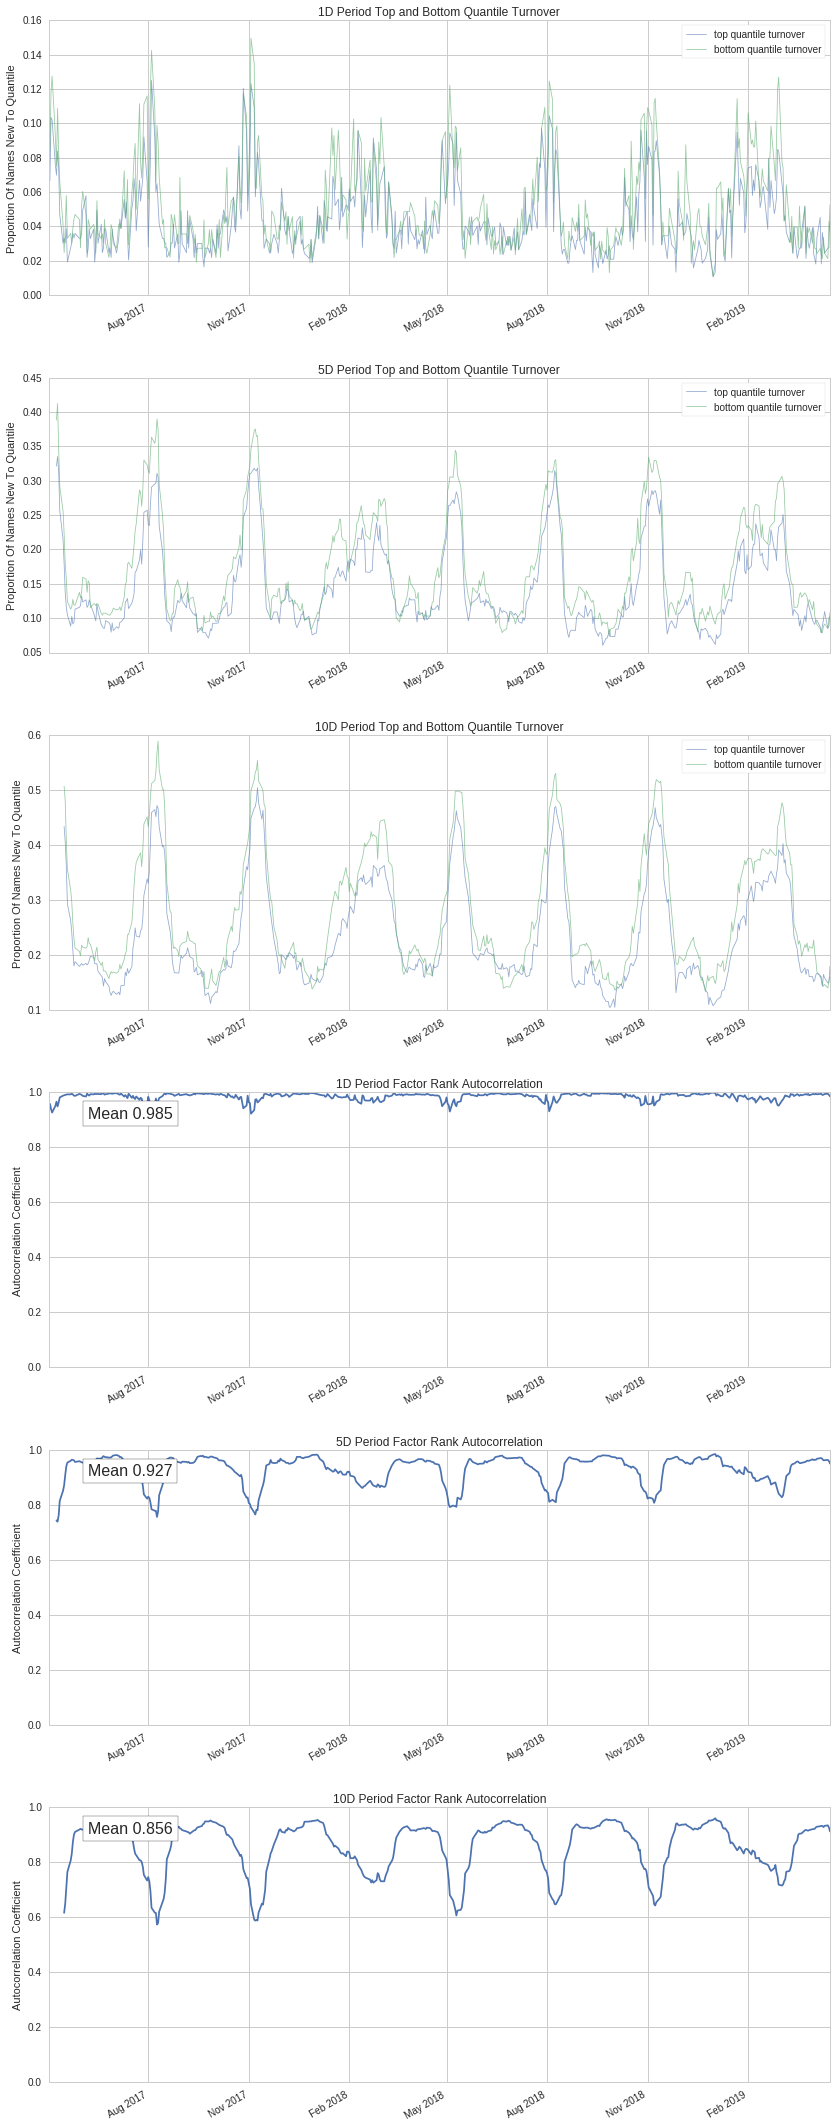

In [5]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(factor_data)

## That's It!

In the next lesson, we will show you how to interpret the charts produced by `create_full_tear_sheet()`.